# Open Street Map

In [20]:
import osmnx as ox
import cartopy.crs as ccrs
ox.settings.log_console=False
ox.settings.use_cache=True

In [27]:
(COORDS, DIST) = ((10.6376,-4.7526), 1000)
PROJ = ccrs.PlateCarree()

In [28]:
BLD = ox.geometries.geometries_from_point(
    COORDS, tags={'building': True} , dist=DIST
)
NTW = ox.graph_from_point(
    COORDS, dist=DIST, network_type='all',
    retain_all=True, simplify=True, truncate_by_edge=True
)
BLD['centroid_lon'] = [poly.centroid.x for poly in BLD['geometry']]
BLD['centroid_lat'] = [poly.centroid.y for poly in BLD['geometry']]
BLD.reset_index(inplace=True)

/var/folders/k2/wvkkz5nn4zbbx6rt5csw2t0m0000gq/T/ipykernel_99959/3517508826.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  BLD = ox.geometries.geometries_from_point(
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs

In [30]:
STYLE_GD_A = {'color': '#8da9c4', 'alpha': 0.5, 'width': 0.5, 'step': 0.01, 'range': 1, 'style': ':'}
STYLE_BG_A = {'color': '#0b2545'}
STYLE_TX_A = {'color': '#faf9f9', 'size': 40}
STYLE_CN_A = {'color': '#faf9f9', 'alpha': 0.20, 'size': 200}
STYLE_BD_A = {'color': '#faf9f9', 'alpha': 0.900}
STYLE_RD_A = {'color': '#ede0d4', 'alpha': 0.125, 'width': 1.5}
MAP_STYLE_A = (
    STYLE_GD_A, STYLE_BG_A, STYLE_TX_A, 
    STYLE_CN_A, STYLE_BD_A, STYLE_RD_A
)
(STYLE_GD, STYLE_BG, STYLE_TX, STYLE_CN, STYLE_BD, STYLE_RD) = MAP_STYLE_A

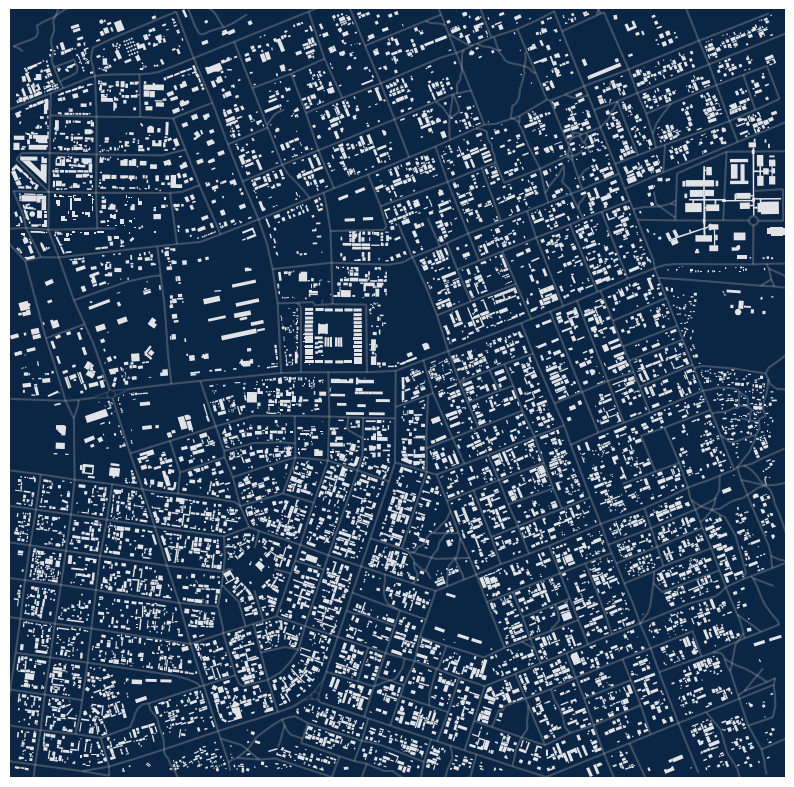

In [31]:
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, node_size=0, figsize=(10, 100), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)

In [32]:
BLD

,element_type,osmid,amenity,building,name,geometry,nodes,cuisine,note,brand,phone,layer,building:levels,source,centroid_lon,centroid_lat
0,node,6359022885,place_of_worship,yes,mosquée du secteur 4,POINT (-4.75463 10.63362),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.754626,10.633622
1,way,128265144,bar,yes,Bar Cascade,"POLYGON ((-4.76129 10.64192, -4.76117 10.64191...","[1417853863, 1417853861, 1417853826, 141785382...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.761233,10.641824
2,way,128265146,restaurant,yes,Mac Donald,"POLYGON ((-4.76183 10.64259, -4.76172 10.64265...","[1417854119, 1417854156, 1417854095, 141785406...",steak_house,"Not one of ""those"" burger places - see http://...",NaN,NaN,NaN,NaN,NaN,-4.761743,10.642571
3,way,128265149,restaurant,yes,Restaurant-Hotel Le Paix,"POLYGON ((-4.76167 10.64228, -4.76167 10.64213...","[1417853959, 1417853912, 1417853919, 141785397...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.761488,10.642203
4,way,128265174,NaN,yes,NaN,"POLYGON ((-4.76172 10.64336, -4.76186 10.64336...","[1417854411, 1417854412, 1417854474, 141785447...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.761791,10.643444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9041,way,571116304,NaN,yes,NaN,"POLYGON ((-4.76172 10.64218, -4.76168 10.64218...","[5489725071, 5489725072, 5489725073, 548972507...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.761703,10.642163
9042,way,571116306,NaN,yes,NaN,"POLYGON ((-4.76161 10.64233, -4.76133 10.64231...","[5489725075, 5489725076, 5489725077, 548972507...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.761469,10.642304
9043,way,571116308,NaN,yes,NaN,"POLYGON ((-4.76131 10.64230, -4.76115 10.64231...","[5489725079, 5489725080, 5489725081, 548972508...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.761228,10.642291
9044,way,621953094,NaN,yes,NaN,"POLYGON ((-4.75884 10.63395, -4.75871 10.63393...","[5875382451, 5875382450, 5875382449, 587538244...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.758783,10.633890
